In [50]:
#Author: YK

# US School Performance Analysis


Objective is two fold: 
1. Evaluate indicators and arrive at metric(s) that can measure school performance
2. And impact policy and funding decisions.

Approach:
1. Analyze the relationship between several factors at the school district & state level that influence
the funding for that district/state (PCA)
2. Compute a metric at school level that encompasses external and internal factors to measure performance. 

$\eta_d = \theta_1(external) + \theta_2(internal)$ + $\epsilon$

where $\eta_d$ gives a metric for school performance (at a district) and $\theta_1 ,  \theta_2$ are parameters to be estimated for future performance (on an annual basis)

The project is designed for the ten most populated States in the US (CA,TX,NY,FL,PA,IL,OH,GA,NC,MI). After collating data for all school districts in these states, apply K-means clustering to identify schools with similar characteristics and perform PCA to see relationships (if any) between the indicators used and the funding for that school district. 

Create external and internal composite variables (either aggregation or transformation technique) using the indicators for each of these to determine a metric $\eta_d$. Then the model is trained (using LASSO regression) to estimate the paraments $\theta_1 , \theta_2$ that will predict school performance for the following year and hence can impact policy and funding decisions.Lastly, the clustering will also aid in validating the school performance metric $\eta$, since comparitive school districts are needed to measure performance of the project. 




## Data Sources:

Data can be requested for variables required at state level:
https://usa.ipums.org/usa/index.shtml

School District level:
1.	Fiscal and non-fiscal district data  from 1989 - 2002
https://nces.ed.gov/edfin/finance_data.asp

2. Census data:
https://data.census.gov/cedsci/
Data can be obtained at school district level




State level:
1.	State nonfiscal survey:  These files include the following data:
•	Directory data for state education agencies
•	State-level student membership counts disaggregated by grade, race/ethnicity and sex
•	State-level staff FTE counts by professional category
https://nces.ed.gov/ccd/stNfis.asp

2.	State education agency websites:
https://nces.ed.gov/ccd/ccseas.asp

3. State level Funding data: 1980-2009
https://www2.ed.gov/about/overview/budget/history/index.html



In [4]:
import os
import glob
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

pd.set_option('display.max_columns',None)


In [14]:
MA_file_path = 'C:\\YK\\Datasets\\MA\\ALL_data'

In [15]:
os.chdir(MA_file_path)

In [37]:
MA_file = glob.glob('*.*')

In [71]:
# read the dropout data for 2018
df_dropout = pd.read_excel(MA_file[1])

In [73]:
df_dropout.head()

,School,Agency ID,Grade_9,Grade_10,Grade_11,Grade_12,Female,Male,Asian,Black,Hispanic,"Multi-Race, Non-Hispanic",Native American,Native Hawaiian,White
0,Abington,2501650,0.6,0,0.8,0.9,0.7,0.4,0.0,0.0,2.4,NaN,NaN,NaN,0.4
1,Agawam,2501800,1.1,1.7,1.1,2.9,0.4,3.1,0.0,0.0,5.6,0.0,NaN,NaN,1.6
2,Amesbury,2501860,0,1.9,0.6,5.2,1.7,2.2,0.0,0.0,2.4,7.7,NaN,NaN,1.7
3,Andover,2501950,0,0,0.2,0.2,0.1,0.1,0.0,0.0,2.0,0.0,NaN,NaN,0.0
4,Arlington,2501980,0,0,1.2,0.9,0.6,0.4,0.0,7.8,2.3,0.0,NaN,NaN,0.1


In [54]:

MA_file_funding = glob.glob('*.xlsx')

In [55]:
MA_file_funding

['droput_rates_by_school_dist_MA.xlsx',
 'droput_rates_by_school_dist_MA_EDITED.xlsx',
 'MA_Funding_chart.xlsx',
 'MA_state_funding_annual.xlsx',
 '~$droput_rates_by_school_dist_MA_EDITED.xlsx']

In [79]:
# read state level funding data
df_funding = pd.read_excel(MA_file_funding[3])

In [33]:
# read school district data for MA
df_MA = pd.DataFrame()
df_MA = pd.read_csv(MA_file[3],encoding='latin-1',low_memory=False)

In [34]:
# keep relevant data; cleanup
df_MA.rename(columns={'Agency ID - NCES Assigned [District] Latest available year':'Agency ID'},inplace=True) 
gender_f = [col for col in df_MA.columns if 'female' in col] 
gender_m = [col for col in df_MA.columns if 'male' in col]

df_MA.drop(columns=(gender_f+gender_m),inplace=True,axis=1)



In [36]:
df_MA.head()

,Agency Name,Agency ID,Total Number Operational Schools [Public School] 2018-19,Total Number Operational Schools [Public School] 2017-18,Total Number Operational Schools [Public School] 2016-17,Total Number Operational Schools [Public School] 2015-16,Total Number Operational Schools [Public School] 2014-15,Total Number Operational Schools [Public School] 2013-14,Total Number Operational Schools [Public School] 2012-13,Total Number Operational Schools [Public School] 2011-12,Total Number Operational Schools [Public School] 2010-11,Total Number Operational Schools [Public School] 2009-10,Grade 9 Students [District] 2018-19,Grade 9 Students [District] 2017-18,Grade 9 Students [District] 2016-17,Grade 9 Students [District] 2015-16,Grade 9 Students [District] 2014-15,Grade 9 Students [District] 2013-14,Grade 9 Students [District] 2012-13,Grade 9 Students [District] 2011-12,Grade 9 Students [District] 2010-11,Grade 10 Students [District] 2018-19,Grade 10 Students [District] 2017-18,Grade 10 Students [District] 2016-17,Grade 10 Students [District] 2015-16,Grade 10 Students [District] 2014-15,Grade 10 Students [District] 2013-14,Grade 10 Students [District] 2012-13,Grade 10 Students [District] 2011-12,Grade 10 Students [District] 2010-11,Grade 11 Students [District] 2018-19,Grade 11 Students [District] 2017-18,Grade 11 Students [District] 2016-17,Grade 11 Students [District] 2015-16,Grade 11 Students [District] 2014-15,Grade 11 Students [District] 2013-14,Grade 11 Students [District] 2012-13,Grade 11 Students [District] 2011-12,Grade 11 Students [District] 2010-11,Grade 12 Students [District] 2018-19,Grade 12 Students [District] 2017-18,Grade 12 Students [District] 2016-17,Grade 12 Students [District] 2015-16,Grade 12 Students [District] 2014-15,Grade 12 Students [District] 2013-14,Grade 12 Students [District] 2012-13,Grade 12 Students [District] 2011-12,Grade 12 Students [District] 2010-11,Secondary Teachers [District] 2018-19,Secondary Teachers [District] 2017-18,Secondary Teachers [District] 2016-17,Secondary Teachers [District] 2015-16,Secondary Teachers [District] 2014-15,Secondary Teachers [District] 2013-14,Secondary Teachers [District] 2012-13,Secondary Teachers [District] 2011-12,Secondary Teachers [District] 2010-11,Secondary Teachers [District] 2009-10,Total Revenue - Local Sources (TLOCREV) [District Finance] 2016-17,Total Revenue - Local Sources (TLOCREV) [District Finance] 2015-16,Total Revenue - Local Sources (TLOCREV) [District Finance] 2014-15,Total Revenue - Local Sources (TLOCREV) [District Finance] 2013-14,Total Revenue - Local Sources (TLOCREV) [District Finance] 2012-13,Total Revenue - Local Sources (TLOCREV) [District Finance] 2011-12,Total Revenue - Local Sources (TLOCREV) [District Finance] 2010-11,Total Revenue - Local Sources (TLOCREV) [District Finance] 2009-10,Total General Revenue (TOTALREV) [District Finance] 2016-17,Total General Revenue (TOTALREV) [District Finance] 2015-16,Total General Revenue (TOTALREV) [District Finance] 2014-15,Total General Revenue (TOTALREV) [District Finance] 2013-14,Total General Revenue (TOTALREV) [District Finance] 2012-13,Total General Revenue (TOTALREV) [District Finance] 2011-12,Total General Revenue (TOTALREV) [District Finance] 2010-11,Total General Revenue (TOTALREV) [District Finance] 2009-10,Total Revenue - State Sources (TSTREV) [District Finance] 2016-17,Total Revenue - State Sources (TSTREV) [District Finance] 2015-16,Total Revenue - State Sources (TSTREV) [District Finance] 2014-15,Total Revenue - State Sources (TSTREV) [District Finance] 2013-14,Total Revenue - State Sources (TSTREV) [District Finance] 2012-13,Total Revenue - State Sources (TSTREV) [District Finance] 2011-12,Total Revenue - State Sources (TSTREV) [District Finance] 2010-11,Total Revenue - State Sources (TSTREV) [District Finance] 2009-10,Total Revenue - Federal Sources (TFEDREV) [District Finance] 2016-17,Total Revenue - Federal Sources (TFEDREV) [District Finance] 2015-16,Total Revenue - Federa

In [47]:
# data in the original file above is combined for all the years; Splitting into files for each year

def split_data(data):
    years = np.arange(2009,2019)
    years = [str(y) for y in years]
    
    # split data into files for each year
    MA_dict = {}
    for y in years:
        df = pd.DataFrame()
        df = data.loc[:, data.columns.str.contains(y)]
        df_ID = data[['Agency Name','Agency ID']].copy() # keep the school name and id
        df = df.join(df_ID)
        
        # process files
        # 1. if the num of schools column has no data, delete those rows
        
        df.rename(columns={df.columns[0]: 'Total Op Schools'},inplace=True)
        df.dropna(subset=['Total Op Schools'], axis=0,inplace=True)          
        
        MA_dict.update({int(y):df})
        
    return MA_dict


In [48]:
all_data_dict = split_data(df_MA)

In [50]:
# aggregating grade data to process with state level data

def get_grade_info(MA_dict):
    
    row_values = []
    for key in MA_dict:
        
        
        if key == 2009: # no grade info available for this year
            continue

        cols = [col for col in MA_dict[key].columns if 'Grade' in col]      
        
           
        df=pd.DataFrame()
        df = MA_dict[key][cols]
        
        df['Num_teachers'] = ""
        df['Year'] = ""
        # rename columns:
        df.columns = ['Grade_9','Grade_10','Grade_11','Grade_12','Num_teachers','Year']
                
        
        # get teacher info:
        teacher_col = [col for col in MA_dict[key].columns if 'Teachers' in col]      
             
        
        dict_temp = {}
        dict_temp.update({'Year':key,'Grade_9':df.Grade_9.mean(),'Grade_10':df.Grade_10.mean(),\
                         'Grade_11':df.Grade_11.mean(),'Grade_12':df.Grade_12.mean(),\
                          'Num_teachers': MA_dict[key][teacher_col[0]].mean()})
        
        row_values.append(dict_temp)

    
    df_grades = pd.DataFrame(row_values)        
    
    return df_grades
        
        
        
    

In [51]:
df_grades = get_grade_info(all_data_dict)

C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda3\envs\ds19\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [52]:
df_grades

,Grade_10,Grade_11,Grade_12,Grade_9,Num_teachers,Year
0,241.727273,238.799342,233.559211,252.571895,61.959530,2016
1,242.265781,238.162791,234.825503,251.809211,63.172931,2017
2,239.839869,233.278689,231.663366,248.732899,64.171823,2018
3,253.548611,244.656250,235.686411,269.798611,59.400765,2010
4,248.178694,242.071918,231.821306,261.740614,58.780125,2011
5,247.479452,240.302405,233.182131,264.361775,59.302574,2012
6,250.730375,239.488055,231.714777,258.158784,59.183325,2013
7,246.483108,242.401361,232.211604,257.285235,61.093951,2014
8,243.275410,238.993377,235.089404,253.349673,60.832801,2015


In [57]:
# merge data at the state level
df = pd.merge(df_grades,df_funding,how='inner',on='Year')
df = df.sort_values('Year')
cols = df.columns
reorder_cols = ['Year','Grade_10', 'Grade_11', 'Grade_12', 'Grade_9', 'Num_teachers','Funding']
df = df[reorder_cols]

In [58]:
df.reset_index(drop=True, inplace=True)

In [64]:
df

,Year,Grade_10,Grade_11,Grade_12,Grade_9,Num_teachers,Funding
2,2010,253.548611,244.656250,235.686411,269.798611,59.400765,4.216387e+09
3,2011,248.178694,242.071918,231.821306,261.740614,58.780125,4.134724e+09
4,2012,247.479452,240.302405,233.182131,264.361775,59.302574,4.057859e+09
5,2013,250.730375,239.488055,231.714777,258.158784,59.183325,3.827931e+09
6,2014,246.483108,242.401361,232.211604,257.285235,61.093951,3.890410e+09
7,2015,243.275410,238.993377,235.089404,253.349673,60.832801,3.951764e+09
0,2016,241.727273,238.799342,233.559211,252.571895,61.959530,4.033029e+09
1,2017,242.265781,238.162791,234.825503,251.809211,63.172931,4.117828e+09


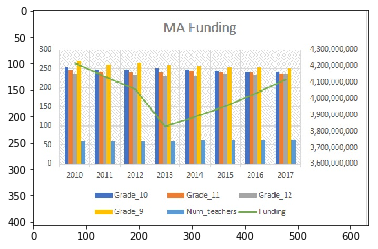

In [53]:
from pylab import imread,subplot,imshow,show

funding_chart = imread('MA_funding.jpg')
plt.imshow(funding_chart)


In [69]:
# dropout data at school level for 2018
df_school_2018 = all_data_dict[2018]
df_school = pd.merge(df_school_2018,df_dropout,how='inner',on='Agency ID')

In [70]:
df_school

,Total Op Schools,Grade 9 Students [District] 2018-19,Grade 10 Students [District] 2018-19,Grade 11 Students [District] 2018-19,Grade 12 Students [District] 2018-19,Secondary Teachers [District] 2018-19,Agency Name,Agency ID,School,Grade_9,Grade_10,Grade_11,Grade_!2,Female,Male,Asian,Black,Hispanic,"Multi-Race, Non-Hispanic",Native American,Native Hawaiian,White
0,5.0,159.0,149.0,125.0,107.0,37.93,ABINGTON,2.50165e+06,Abington,0.6,0,0.8,0.9,0.7,0.4,0.0,0.0,2.4,NaN,NaN,NaN,0.4
1,9.0,460.0,429.0,445.0,500.0,124.84,ACTON-BOXBOROUGH,2.50171e+06,Acton-Boxborough,0,0.5,0.0,1.2,0.3,0.5,0.2,0.0,1.4,0.0,NaN,NaN,0.6
2,3.0,81.0,50.0,74.0,87.0,31.85,ADAMS-CHESHIRE,2.50178e+06,Adams-Cheshire,1.2,0,2.7,2.3,2.8,0.7,0.0,0.0,22.2,NaN,NaN,NaN,1.2
3,8.0,265.0,292.0,270.0,277.0,93.90,AGAWAM,2.5018e+06,Agawam,1.1,1.7,1.1,2.9,0.4,3.1,0.0,0.0,5.6,0.0,NaN,NaN,1.6
4,5.0,146.0,155.0,157.0,153.0,51.04,AMESBURY,2.50186e+06,Amesbury,0,1.9,0.6,5.2,1.7,2.2,0.0,0.0,2.4,7.7,NaN,NaN,1.7
5,2.0,231.0,231.0,230.0,225.0,70.81,AMHERST-PELHAM,2.50192e+06,Amherst-Pelham,0,1.3,0.9,3.6,0.9,2.0,0.0,1.6,4.8,1.3,NaN,NaN,0.7
6,10.0,426.0,460.0,430.0,445.0,124.15,ANDOVER,2.50195e+06,Andover,0,0,0.2,0.2,0.1,0.1,0.0,0.0,2.0,0.0,NaN,NaN,0.0
7,11.0,364.0,344.0,328.0,344.0,100.92,ARLINGTON,2.50198e+06,Arlington,0,0,1.2,0.9,0.6,0.4,0.0,7.8,2.3,0.0,NaN,NaN,0.1
8,5.0,145.0,174.0,179.0,159.0,49.11,ASHBURNHAM-WESTMINSTER,2.50204e+06,Ashburnham-Westminster,0,1.1,0.6,0.6,0.0,1.2,0.0,NaN,0.0,0.0,NaN,NaN,0.6
9,5.0,224.0,210.0,214.0,184.0,56.40,ASHLAND,2.5021e+06,Ashland,0.4,0,1.4,0.5,0.2,1.0,0.0,0.0,3.2,0.0,NaN,NaN,0.3


In [76]:
def dropout_2018(df_drop,df):
    dict_drop = {}
    dict_drop.update({'Grade_9':df.Grade_9.mean(),'Grade_10':df.Grade_10.mean(),\
                         'Grade_11':df.Grade_11.mean(),'Grade_12':df.Grade_12.mean(),\
                      'Grade_9_drop':df_drop.Grade_9.mean(),'Grade_10_drop':df_drop.Grade_10.mean(),\
                         'Grade_11_drop':df_drop.Grade_11.mean(),'Grade_12_drop':df_drop.Grade_12.mean()                     
                      
                     })
    
    df_2018 = pd.DataFrame(dict_drop)
    return df_2018
        
    

In [78]:
#df_2018_all = dropout_2018(df_dropout,df_school_2018)